# 0. Stable Diffusion Playground

This notebook demonstrates the use of Stable Diffusion 1.5 for image generation, activation caching, and concept unlearning using Sparse Autoencoders (SAE).

- **Model**: Stable Diffusion v1.5
- **Key Features**: Activation extraction, feature selection for unlearning, and visualization of concepts.
- **Requirements**: PyTorch with CUDA support recommended for performance.

## Setup and Imports

This section handles imports, device configuration, and environment checks.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from diffusers import StableDiffusionPipeline
from PIL import Image
from typing import List
from io import BytesIO
from IPython.display import display, Image as IPImage # Zmieniamy nazwę Image, żeby uniknąć konfliktu z PIL.Image

# SAE part
import overcomplete
from einops import rearrange
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae
from overcomplete.visualization import overlay_top_heatmaps


model_id = "sd-legacy/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print(f"PyTorch CUDA version: {torch.version.cuda}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Using device: {device}")

CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch CUDA version: 11.8
CUDA device count: 1
Using device: cuda


## Utility Functions

Functions for displaying images and sequences.

In [2]:
def display_image(
    image: Image.Image, 
    title: str = ""
):
    """
    Wyświetla pojedynczy obraz PIL.Image.
    
    Args:
        image (Image.Image): Obiekt PIL.Image do wyświetlenia.
        title (str): Tytuł wykresu.
    """
    if not isinstance(image, Image.Image):
        print("Błąd: Oczekiwano pojedynczego obiektu PIL.Image.")
        return

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()



def display_sequence(
    images: List[Image.Image], 
    title: str = "",
    max_cols: int = 5,
    sampling_rate: int = 1
):
    """
    Wyświetla sekwencję obrazów PIL.Image w siatce, pokazując zmianę czasową.
    
    Args:
        images (List[Image.Image]): Lista obiektów PIL.Image (kroki generacji).
        title (str): Główny tytuł wykresu.
        max_cols (int): Maksymalna liczba kolumn w siatce.
        sampling_rate (int): Wyświetla co N-ty obraz z listy, aby skrócić sekwencję.
    """
    if not isinstance(images, list) or not all(isinstance(img, Image.Image) for img in images):
        print("Błąd: Oczekiwano listy obiektów PIL.Image.")
        return
    if not images:
        print("Lista obrazów jest pusta.")
        return

    # --- Wybór obrazów do wyświetlenia (próbkowanie) ---
    display_list = []
    display_indices = []
    
    # Próbkujemy co 'sampling_rate' kroków
    for i in range(0, len(images), sampling_rate):
        display_list.append(images[i])
        display_indices.append(i)

    # Upewnienie się, że ostatni krok jest zawsze widoczny
    last_idx = len(images) - 1
    if last_idx not in display_indices:
        display_list.append(images[last_idx])
        display_indices.append(last_idx)
    
    # --- Konfiguracja Siatki ---
    num_to_display = len(display_list)
    cols = min(num_to_display, max_cols)
    rows = (num_to_display + cols - 1) // cols

    plt.figure(figsize=(3 * cols, 3 * rows))
    plt.suptitle(title, fontsize=16)

    # --- Rysowanie Obrazów w Siatce ---
    for i, (img, original_idx) in enumerate(zip(display_list, display_indices)):
        ax = plt.subplot(rows, cols, i + 1)
        
        plt.imshow(img)
        
        # Tytuł: Numer kroku
        ax.set_title(f"Krok: {original_idx + 1}/{len(images)}", fontsize=10)
        
        ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    

def display_gif_in_notebook(frames: List[Image.Image], duration: int = 100):
    """
    Generuje animację GIF z listy klatek PIL.Image i wyświetla ją bezpośrednio 
    w środowisku Jupyter/Colab bez zapisywania pliku na dysku.
    
    Args:
        frames (List[Image.Image]): Lista obiektów PIL.Image (klatki animacji).
        duration (int): Czas trwania jednej klatki w milisekundach.
    """
    if not frames:
        print("Błąd: Lista klatek jest pusta.")
        return

    # Używamy BytesIO do zapisania GIF-a w pamięci RAM
    buffer = BytesIO()
    
    # Tworzenie GIF-a i zapis do bufora
    frames[0].save(
        buffer,
        format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=0  # 0 oznacza zapętlenie w nieskończoność
    )
    
    # Resetowanie wskaźnika bufora na początek
    buffer.seek(0)

    # Wyświetlanie GIF-a w notatniku za pomocą IPython.display
    print(f"Wyświetlanie animacji GIF ({len(frames)} klatek, {duration}ms/klatka):")
    display(IPImage(data=buffer.read(), format='gif'))


# 1. Activation Extraction

Callback to cache activations from specific layers.

In [ ]:
step_images = []
cached_activations = {}


# def callback_handler(step: int, timestep: int, latents: torch.FloatTensor):

#     """
#     Funkcja wywoływana po każdym kroku denoisowania.
#     Konwertuje aktualny latentny tensor na obraz i zapisuje go.
#     """
#     global step_images
    
#     # 1. Weź pierwszy element (batch size 1) i odłącz go od grafu
#     latent_to_decode = latents[0].detach()
    
#     # 2. Przekaż latentny tensor do VAE (dekoder)
#     # Wymaga to pewnej manipulacji wymiarami i typem danych
    
#     # Zmniejszenie skali (dekoder wymaga innej skali)
#     latent_to_decode = 1 / pipe.vae.config.scaling_factor * latent_to_decode
    
#     # Przejście przez dekoder VAE
#     with torch.no_grad():
#         image = pipe.vae.decode(latent_to_decode.unsqueeze(0)).sample
    
#     # Post-processing obrazu
#     image = (image / 2 + 0.5).clamp(0, 1)
#     image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
#     image = Image.fromarray((image * 255).astype("uint8"))
    
#     # Zapisanie obrazu i informacji o kroku
#     step_images.append(image)
#     print(f"Timestep {timestep} zapisany.")
    
#     # Zwrócenie None jest standardowe dla callbacków w diffusers
#     return None

In [ ]:
def save_activation(name):
    def hook(model, input, output):
        if isinstance(output, tuple):
            output = output[0]
        
        if output.shape[0] == 2:
            # Weź conditional i konwertuj do float32
            cached_activations[name] = output[1:2].detach().cpu().float() 
        else:
            cached_activations[name] = output.detach().cpu().float()
    return hook

Struktura U-Net (pipe.unet):

In [6]:
# Struktura U-Net (pipe.unet):
# ----------------------------------------------------------------------------------
# I. DOWN BLOCKS (Bloki obniżające rozdzielczość, 4 bloki: 0, 1, 2, 3)
#    Liczba bloków: pipe.unet.down_blocks (4 elementy: 0, 1, 2, 3)
#    W każdym bloku są 2 warstwy ResNet + 2 warstwy Transformer (z wyjątkiem bloku 0)

# Bloki Transformer (zawierają Cross-Attention, którym jesteśmy zainteresowani) są w:
# Down Block 1: pipe.unet.down_blocks[1].attentions (2 moduły)
# Down Block 2: pipe.unet.down_blocks[2].attentions (2 moduły)
# Down Block 3: pipe.unet.down_blocks[3].attentions (3 moduły) <- Tu są też warstwy ResNet/Downsample
# ----------------------------------------------------------------------------------

# II. MID BLOCK (Blok środkowy)
#    pipe.unet.mid_block
#    Zawiera 1 ResNet Block + 1 Transformer Block
#    Ścieżka do Cross-Attention: pipe.unet.mid_block.attentions[0].transformer_blocks[0]
# ----------------------------------------------------------------------------------

# III. UP BLOCKS (Bloki podwyższające rozdzielczość, 4 bloki: 0, 1, 2, 3)
#    Liczba bloków: pipe.unet.up_blocks (4 elementy: 0, 1, 2, 3)
#    Każdy blok zawiera 3 warstwy Transformer (z wyjątkiem bloku 3) + 3 ResNet + UpSample

# Bloki Transformer (z Cross-Attention) są w:
# Up Block 0: pipe.unet.up_blocks[0].attentions (3 moduły)
# Up Block 1: pipe.unet.up_blocks[1].attentions (3 moduły)
# Up Block 2: pipe.unet.up_blocks[2].attentions (3 moduły)
# ----------------------------------------------------------------------------------

# 2. SAeUron
Latent space representation learning and modification, includes:
- **training**
- **usage in SD**
- **feature selection**

## SAE training

In [ ]:
# def criterion(x, x_hat, pre_codes, codes, dictionary):
#   mse = (x - x_hat).square().mean()
#   return mse

def criterion(x, x_hat, pre_codes, codes, dictionary):
        """ 
        Custom criterion function for Sparse Autoencoder (SAE) training.
        Args:
            x (torch.Tensor): Original input tensor.
            x_hat (torch.Tensor): Reconstructed output tensor from the SAE.
            pre_codes (torch.Tensor): Pre-activation codes from the encoder.
            codes (torch.Tensor): Final sparse codes after applying top-k sparsity.
            dictionary (torch.Tensor): The learned dictionary (decoder weights).
        n (int): Dimensionality of the input features.
        Returns:
            torch.Tensor: The computed loss value.
        """
        # Compute reconstruction MSE
        mse = torch.mean((x - x_hat) ** 2)
        
        # Hyperparameters (these could be passed as arguments or globals)
        alpha = 1/32  # Scaling factor for auxiliary loss
        k_aux = n//2   # Number of least active features for auxiliary loss
        
        # Compute mean activation per feature across the batch
        feature_acts = codes.mean(dim=0)
        
        # Select indices of k_aux features with the lowest mean activations (potential dead latents)
        low_act_indices = torch.topk(feature_acts, k_aux, largest=False)[1]
        
        # Create a masked codes tensor using only the low-activation features
        codes_aux = torch.zeros_like(codes)
        codes_aux[:, low_act_indices] = codes[:, low_act_indices]
        
        # Reconstruct using only these features (assuming dictionary is W_dec and no b_pre for simplicity)
        x_aux = torch.matmul(codes_aux, dictionary)
        
        # Compute auxiliary MSE on this partial reconstruction
        l_aux = torch.mean((x - x_aux) ** 2)
        
        # Total metric: MSE + alpha * L_aux
        metric = mse + alpha * l_aux
        
        return metric

def sae_train(Activations,criterion,expansion_factor,top_k,batch_size,num_epochs,learning_rate):

    # Initialize feature dimensionality
    d = Activations.shape[-1]

    # Initialize the Sparse Autoencoder (SAE), DataLoader, and Optimizer
    sae = TopKSAE(d, nb_concepts=expansion_factor*d, top_k=top_k, device='cuda')
    dataloader = DataLoader(TensorDataset(Activations), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(sae.parameters(), lr=learning_rate)

    # Train the SAE
    logs = train_sae(sae, dataloader, criterion, optimizer, nb_epochs=15, device='cuda')
    sae = sae.eval()
    
    return sae

## SAE in between layers

Define callback (different from the one to collect step images) and integration hook

Functions need global variables:
 - step_images - [ ]
 - pipe - StableDiffusionPipeline.from_pretrained object
 - sae_encodings - [ ]
 - concept_vector - torch.tensor
 - sae - TopKSAE object


In [ ]:
step_images = []
sae_encodings = []
n = 1280 # wymiar d ,ilość cech wejściowych
expansion_factor = 16 # współczynnik rozszerzenia

# przykładowe indeksy koncepcji do oduczenia
concept_indices = [39, 41, 78, 109, 154, 328, 362, 413, 513, 708]
concept_vector = torch.zeros(n*expansion_factor, device='cuda') # n - wymiar d , expansion_factor - współczynnik rozszerzenia
concept_vector[concept_indices] = 1

In [ ]:
def callback_handler(self, step: int, timestep: int, callback_kwargs: dict):
    global step_images, pipe
    
    try:
        latents = callback_kwargs["latents"]
        latent_to_decode = latents[0].detach()
        latent_to_decode = 1 / pipe.vae.config.scaling_factor * latent_to_decode
        
        with torch.no_grad():
            image = pipe.vae.decode(latent_to_decode.unsqueeze(0)).sample
        
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        image = Image.fromarray((image * 255).astype("uint8"))
        
        step_images.append(image)
        print(f"Timestep {timestep}")
        return {}
    except Exception as e:
        print(f"Callback error: {e}")
        return {}

In [81]:
def latent_modification(codes: torch.Tensor) -> torch.Tensor:
    """
    Modyfikuje wybrane koncepcje w reprezentacji latentnej.
    
    Args:
        codes (torch.Tensor): Tensor kodów latentnych o wymiarach (batch_size, num_concepts).
    Returns:
        torch.Tensor: Zmodyfikowany tensor kodów latentnych.
    """
    global concept_vector
    modified_codes = codes - 100 * (codes * concept_vector)  # Zero out selected concepts
    return modified_codes

In [ ]:
def sae_integration_hook(module, input, output):
    """ Hook integrujący SAE z modelem U-Net.
    args:
        module: Moduł, do którego jest podłączony hook.
        input: Wejście do modułu (nieużywane tutaj).
        output: Wyjście z modułu (aktywacje U-Net).
    """
    try:
        global sae_encodings, concept_vector, sae
        if isinstance(output, tuple):
            act = output[0]
        else:
            act = output
        original_dtype = act.dtype  # Should be torch.float16
        act = act.float()
        batch, seq_len, dim = act.shape
        act_reshaped = rearrange(act, 'b t d -> (b t) d')
        with torch.no_grad():
            pre_codes, codes = sae.encode(act_reshaped)  # sae on 'cuda'
            modified_codes = latent_modification(codes)
            act_reconstructed = sae.decode(modified_codes)
            act_reconstructed = rearrange(act_reconstructed, '(b t) d -> b t d', b=batch, t=seq_len)
            act_reconstructed = act_reconstructed.to(dtype=original_dtype)
        sae_encodings.append({
            'pre_codes': pre_codes,  # Keep on GPU
            'codes': codes,
            'modified_codes': modified_codes
        })
        if isinstance(output, tuple):
            return (act_reconstructed,) + output[1:]
        return act_reconstructed
    except Exception as e:
        print(f"Hook error: {e}")
        raise

## SEA feature selection

In [ ]:
def select_features(activations_concept_true_tensor, activations_concept_false_tensor, n_features, sae):
    """
    Wybiera cechy o największej różnicy średnich wartości między dwiema grupami aktywacji.
    
    Args:
        activations_concept_true_tensor (torch.Tensor): Tensor aktywacji dla grupy "true" o kształcie [num_images, num_samples, num_d_maps].
        activations_concept_false_tensor (torch.Tensor): Tensor aktywacji dla grupy "false" o kształcie [num_images, num_samples, num_d_maps].
        n_features (int): Liczba cech do wybrania.
        
    Returns:
        List[int]: Lista indeksów wybranych cech.
    """
    # Move tensors to the same device as the SAE model
    device = next(sae.parameters()).device
    activations_concept_true_tensor = activations_concept_true_tensor.to(device, non_blocking=True)
    activations_concept_false_tensor = activations_concept_false_tensor.to(device, non_blocking=True)
    
    num_d_maps = activations_concept_true_tensor.shape[2]
    
    # Reshape and encode once for all features
    true_flat = activations_concept_true_tensor.reshape(-1, num_d_maps)
    false_flat = activations_concept_false_tensor.reshape(-1, num_d_maps)
    print(f"Encoding {true_flat.shape[0]} true samples and {false_flat.shape[0]} false samples...")
    codes_true = sae.encode(true_flat)[1]
    codes_false = sae.encode(false_flat)[1]
    
    # Compute sums of means 
    sum_code_means_true = codes_true.sum(dim=0)
    sum_code_means_false = codes_false.sum(dim=0)
    
    # Vectorized computation of mean differences
    mean_true = codes_true.mean(dim=0)
    mean_false = codes_false.mean(dim=0)
    normalized_diff = (mean_true / (sum_code_means_true + 1e-8)) - (mean_false / (sum_code_means_false + 1e-8))
    
    # Sort and select top n_features
    feature_indices = torch.argsort(normalized_diff, descending=True)
    selected_features = feature_indices[:n_features].tolist()
    
    return selected_features

# x. Usage examples

Here are some test and examples of functions usage

## Model loading and activation caching

Model loading

In [39]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, 
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Dodanie hooków do warstw Cross-Attention w U-Net

In [40]:
cached_activations = {}
hook_handles = []

# 1. Wybór Reprezentacji Tekstowej (Text Embedding)
# Wyjście ostatniej warstwy Text Encodera (zawsze ma wymiar: [1, 77, 768])
text_encoder_output_layer = pipe.text_encoder.text_model.encoder.layers[-1]
hook_handles.append(
    text_encoder_output_layer.register_forward_hook(
        save_activation("text_embedding")
    )
)

# 2. Wybór Arbitralnej Warstwy Latentnej U-Net (np. drugi Transformer w Down Block 2)
# Używamy .transformer_blocks[0] w AttentionBlocku
target_unet_block_path = pipe.unet.up_blocks[1].attentions[1].transformer_blocks[0]
hook_handles.append(
    target_unet_block_path.register_forward_hook(
        save_activation("unet_latent_up_block_1_att_1")
    )
)

Model inference

  0%|          | 0/10 [00:00<?, ?it/s]

Timestep 901
Timestep 801
Timestep 801
Timestep 701
Timestep 601
Timestep 501
Timestep 401
Timestep 301
Timestep 201
Timestep 101
Timestep 1


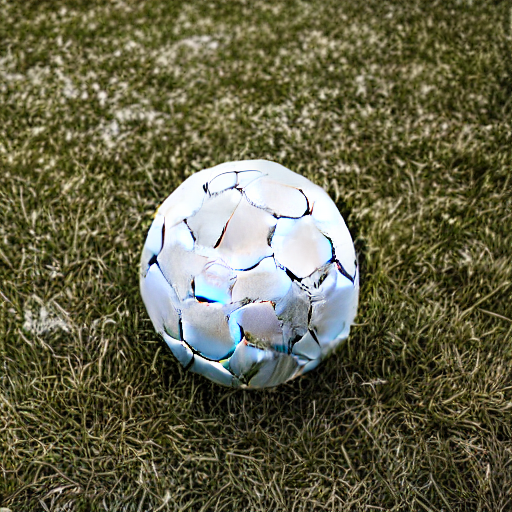

In [ ]:
num_inference_steps = 10
guidance_scale = 8.0
num_images_per_prompt = 1
prompt = "a football ball"
negative_prompt = ""
generator = torch.Generator(device).manual_seed(42)

image = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=generator,
    callback_on_step_end=callback_handler,
    callback_steps=1,  # Wywołaj callback po każdym kroku
    num_images_per_prompt=num_images_per_prompt,
    negative_prompt=negative_prompt
).images[0]

display(image)

In [20]:
cached_activations['unet_latent_up_block_1_att_1'].shape

torch.Size([1, 256, 1280])

Zapis aktywacji w postaci tensora do pliku

In [ ]:
# Przetwarzanie zapisanych aktywacji do formatu przyjaznego do trenowania SAE
guided_cached_activations = {}
for i in range(0, cached_activations['unet_latent_up_block_1_att_1'].shape[0], 2):
    guided_cached_activations[i//2] = cached_activations['unet_latent_up_block_1_att_1'][i:i+1]

# Change to a tensor of shape (num_steps, batch_size=1, channels, height, width)
guided_cached_activations_tensor = torch.cat(list(guided_cached_activations.values()), dim=0)
# Save guided_cached_activations_tensor to file for later use
torch.save(guided_cached_activations_tensor, "guided_cached_activations_tensor.pt")

# Load guided_cached_activations_tensor from file
# guided_cached_activations_tensor = torch.load("guided_cached_activations_tensor.pt")

torch.Size([20, 256, 1280])

## SAE trining example

1. Get activations

In [30]:
Activations = torch.load("guided_cached_activations_tensor.pt")
Activations = Activations.float()  # Konwersja z float16 → float32
Activations.shape

torch.Size([20, 256, 1280])

2. Transform into 

In [31]:
Activations = rearrange(Activations, 'n t d -> (n t) d').float()
Activations.shape

torch.Size([5120, 1280])

3. Use SAE

In [32]:
sae = sae_train(Activations,criterion=criterion,expansion_factor=16,top_k=32,batch_size=1024,num_epochs=15,learning_rate=1e-3)

Epoch[1/15], Loss: 1.1027, R2: -0.0282, L0: 32.0000, Dead Features: 3.2%, Time: 1.5172 seconds
Epoch[2/15], Loss: 0.9060, R2: 0.1609, L0: 32.0000, Dead Features: 37.5%, Time: 1.0375 seconds
Epoch[3/15], Loss: 0.7345, R2: 0.3258, L0: 32.0000, Dead Features: 72.6%, Time: 1.1301 seconds
Epoch[4/15], Loss: 0.6068, R2: 0.4483, L0: 32.0000, Dead Features: 72.4%, Time: 1.2041 seconds
Epoch[5/15], Loss: 0.5076, R2: 0.5437, L0: 32.0000, Dead Features: 71.9%, Time: 1.1748 seconds
Epoch[6/15], Loss: 0.4275, R2: 0.6206, L0: 32.0000, Dead Features: 71.7%, Time: 1.2138 seconds
Epoch[7/15], Loss: 0.3632, R2: 0.6823, L0: 32.0000, Dead Features: 71.0%, Time: 1.2206 seconds
Epoch[8/15], Loss: 0.3107, R2: 0.7328, L0: 32.0000, Dead Features: 70.7%, Time: 1.2141 seconds
Epoch[9/15], Loss: 0.2675, R2: 0.7743, L0: 32.0000, Dead Features: 70.0%, Time: 0.9551 seconds
Epoch[10/15], Loss: 0.2317, R2: 0.8086, L0: 32.0000, Dead Features: 69.2%, Time: 1.0527 seconds
Epoch[11/15], Loss: 0.2019, R2: 0.8374, L0: 32.00

## SEA feature selection

In [ ]:
guided_cached_activations = torch.load("guided_cached_activations.pt")
# convert to tensor of shape (num_steps, batch_size=1, channels, height, width)
guided_cached_activations_tensor_true = torch.cat(list(guided_cached_activations.values()), dim=0)

guided_cached_activations_tensor_false = torch.load("guided_cached_activations_tensor.pt")

In [ ]:
# example usage
select_features(guided_cached_activations_tensor_true, guided_cached_activations_tensor_false, 10, sae)

Encoding 5120 true samples and 5120 false samples...
torch.Size([5120, 20480]) torch.Size([5120, 20480])
torch.Size([20480])


[39, 41, 78, 109, 154, 328, 362, 413, 513, 708]

## Inference with SAE integration

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, 
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [34]:
# Register the hook after training SAE
hook_handles = []
target_unet_block = pipe.unet.up_blocks[1].attentions[1].transformer_blocks[0]
hook_handles.append(target_unet_block.register_forward_hook(sae_integration_hook))

c:\Users\jancw\anaconda3\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:905: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(


  0%|          | 0/10 [00:00<?, ?it/s]

Timestep 901
Timestep 801
Timestep 801
Timestep 701
Timestep 601
Timestep 501
Timestep 401
Timestep 301
Timestep 201
Timestep 101
Timestep 1


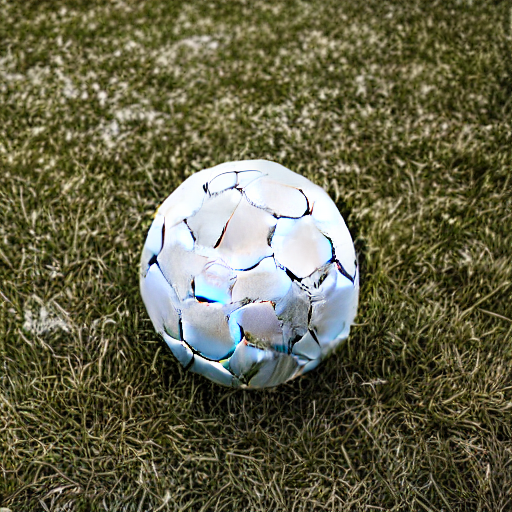

Extracted 16 sets of encodings (one per step).


In [76]:
# Clear previous encodings
num_inference_steps = 10
guidance_scale = 8.0
num_images_per_prompt = 1
prompt = "a football ball"
negative_prompt = ""
generator = torch.Generator(device).manual_seed(42)

image = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=generator,
    callback_on_step_end=callback_handler,
    callback_steps=1,  # Wywołaj callback po każdym kroku
    num_images_per_prompt=num_images_per_prompt,
    negative_prompt=negative_prompt
).images[0]

display(image)

# After generation, inspect extracted encodings
print(f"Extracted {len(sae_encodings)} sets of encodings (one per step).")

## Visualization of concept extraction
requires cached_activations,sae,image

In [36]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, 
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
# needs 
Activations = cached_activations['unet_latent_up_block_1_att_1'].to(device)
with torch.no_grad():
    pre_codes, codes = sae.encode(Activations.reshape(-1, Activations.shape[-1]))

codes = rearrange(codes, '(b t) d -> b t d', b=Activations.shape[0], t=Activations.shape[1])
codes = rearrange(codes, 'b (w h) d -> b w h d', w=16, h=16)

image_tensor = np.array(image) # shape (H, W, C)
image_tensor = torch.tensor(image_tensor).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0  # shape (1, C, H, W)

Concept 39


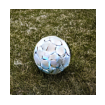

Concept 41


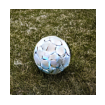

Concept 78


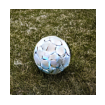

Concept 109


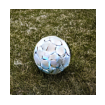

Concept 154


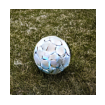

Concept 328


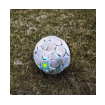

Concept 362


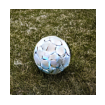

Concept 413


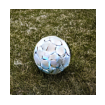

Concept 513


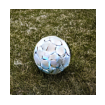

Concept 708


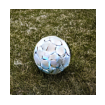

In [ ]:
for i in [39, 41, 78, 109, 154, 328, 362, 413, 513, 708]:
  print('Concept', i)
  overlay_top_heatmaps(image_tensor, codes, concept_id=i) # image_tensor: tensor shape (B, C, H, W), codes: tensor shape (B, C, 16, D)
  plt.show()